#Project Overview

# Need to add summary of the project etc.....

In [ ]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import pandasql as ps
from collections import namedtuple
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, classification_report
from time import time
import gensim
import random 
import scipy
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline 

# Part 1 : Import Data, Data Extraction & Cleaning




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/Shareddrives/CIS 519 Project

/content/drive/Shareddrives/CIS 519 Project


###Exploratory Data Analysis

Before building our recurrent neural network we will start by exploring our dataset. You can download the Reviews.csv file from Kaggle. Let's start by loading the data.

In [ ]:
csv_file = '/content/drive/Shareddrives/CIS 519 Project/Reviews.csv'

In [ ]:
data = pd.read_csv(csv_file)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
print("Number of reviews:",data.shape[0])
print("Number of columns:", data.shape[1])

Number of reviews: 568454
Number of columns: 10


The dataset contains 568,454 food reviews and 10 columns.

The Text column contains the review for a specific product by various users, which consists of unstructured text data. The ProductId column contains the product's identification number for each specific product. The UserID column contains the idenfication numb for Amazon user. The time column contains the date of the review was posted. The Summary column contains a brief summary of the review. Additionally, HelpfulnessNumerator and HelpfulnessDenominator, two variables representing how helpful a review is, are also provided in the review.

More importantly, for each review, we have a “Score” variable representing a rating from 1 to 5 (1 is a poor review, and 5 is an excellent review).

###Get Mean/Median/Percentile/Standard Deviation information

In [ ]:
#Brief description about the dataset
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


###Number of reviews corresponding to each of the ratings.

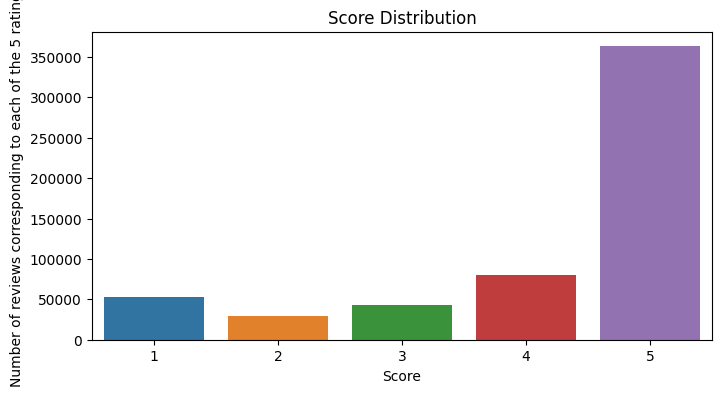

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64


In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x = data['Score'])
plt.title("Score Distribution")
plt.xlabel("Score")
plt.ylabel("Number of reviews corresponding to each of the 5 ratings")
plt.show()

print(data['Score'].value_counts())

Here, we can observe that the majority of Scores are equal to 4 and 5, and with an average score of 4.18. There are 63.8% reviews have rating equal to 5, 14.1% reviews have rating equal to 4, 7.5% reviews have rating equal to 3, 5.2% revies have ratings equal to 2 and lastly 9.1% reviews have ratings equal to 1. This shows that most of the reviews that are there in the dataset has a very high rating of 5. The next most prevalent rating is 4-stars(14%), followed by 1-star (9%), 3-star (7%), and finally 2-star reviews (5%). So, going by the naive approach we can clearly see that almost 78% of the reviews are positive.


##Naive Way

The naive way of doing this is to categorize all reviews with score of 4 and 5 as positive. The reviews with score 1 and 2 as negative. We will ignore the reviews with score of 3 because it is being considered as a neutral score. 


In [ ]:
#Filter only positive and negative reviews. Do not consider reviews with score = 3.
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
filtered_df = data[data['Score'] != 3]

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_df['Sentiment'] = filtered_df['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_df['Class_Labels'] = filtered_df['Sentiment'].apply(lambda x : 1 if x == 'Positive' else 0)
filtered_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


From the newly added Sentiment column, we can say either a Review is positive or negative. Then, we get this new distribution:

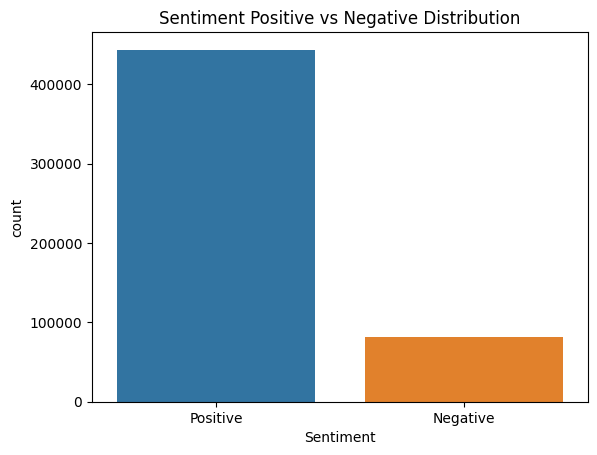

In [ ]:
ax = plt.axes()
sns.countplot(x = filtered_df['Sentiment'],ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [ ]:
print("Proportion of positive review:", len(filtered_df[filtered_df['Sentiment']=='Positive'])/len(filtered_df))
print("Proportion of positive review:",len(filtered_df[filtered_df['Sentiment']=='Negative'])/len(filtered_df))

Proportion of positive review: 0.843980951439102
Proportion of positive review: 0.15601904856089796


With this new classification, 84% of the fine food reviews are considered as positive and 15% of them are considered as negative.

Since we only need the reviews in the Text column as an input for our model and the Sentiment (positive or negative) as an ouput, we will store this information in a reviews and sentiment variables.

In [ ]:
reviews = filtered_df['Text'].values
labels = filtered_df['Sentiment'].values

###Text Reviews

We now explore our input variable "Text" which contains the review of the product.

In [ ]:
def print_review_and_label(i):
    if filtered_df.Sentiment[i]== 'Positive':
        print("POSITIVE" + "\t" + reviews[i][:90] + "...")
    else:
        print("NEGATIVE" + "\t " + reviews[i][:90] + "...")

In [ ]:
print_review_and_label(1)
print_review_and_label(9)
print_review_and_label(15)
print_review_and_label(80)

NEGATIVE	 Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized un...
POSITIVE	This is a very healthy dog food. Good for their digestion. Also good for small puppies. My...
POSITIVE	My daughter loves twizzlers and this shipment of six pounds really hit the spot. It's exac...
POSITIVE	Great food! I love the idea of one food for all ages & breeds. Ît's a real convenience as ...



By looking at the first 90 characters, we can quickly grasp an idea of whether the review is positive or negative. For the negative reviews, we have negative expressions such as "not good", or "don't like it." These negative expressions can also be more nuanced depending on the context, such as "were actually small sized." For positive reviews, users use positive expression such as "Great food", "great price", "very healthy dog food", "really hit the spot", etc.

It's important to note that the text is unstructured, and we will have to do some pre-processing to remove punctuations, transform upper-case to lower case, etc.


## Data Cleaning and Preprocessing



First, we will remove any duplicate data. There exist a lot of duplicates (161641) where the different products is reviewed by same user at the same time stamp. The product ID may be different but the product is similar with different variant.

In [ ]:
#Get the number of duplicate entries in the dataset.
filtered_df.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts()

False    364173
True     161641
dtype: int64

In [ ]:
#Display Duplicates
display = filtered_df[filtered_df['UserId'] == 'AR5J8UI46CURR']
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Class_Labels
73790,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
78444,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
138276,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
138316,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1
155048,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...,Positive,1


Notice in the displayed dataframe above, the user named Geeta Krishnan gave the review at the same timestamp for multiple products. However, they were reviews for the same products with different flavours and they were counted as multiple products.


In [ ]:
#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_df.shape))
print("The median score values : {}".format(filtered_df['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_df["Sentiment"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: Sentiment, dtype: int64


In [ ]:
#Removing duplicate entries based on past knowledge.
filtered = filtered_df.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(filtered.shape))

The shape of the data matrix after deduplication, Stage 1: (364173, 12)


In [ ]:
#Checking to see how much % of data still remains.
print("Checking to see how much percentage of data still remains.")
retained_per = (filtered['Sentiment'].size*1.0)/(filtered_df['Sentiment'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(np.round(removed_per,2)))
print("Percentage of original data retained : {}".format(np.round(retained_per,2)))

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.74
Percentage of original data retained : 69.26


###Text Preprocessing


*   Remove URL and Punctuations






In [ ]:
#Function to clean html tags from a sentence
import re
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

filtered['Text'] = filtered['Text'].apply(lambda x: removeHtml(x))

In [ ]:
# remove punctuation
def remove_punctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

filtered['Text'] = filtered['Text'].apply(lambda x: remove_punctuations(x))

*   Removal of words with numbers



In [ ]:
#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def remove_numbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

filtered['Text'] = filtered['Text'].apply(lambda x: remove_numbers(x))

*   Remove URL from sentence




In [ ]:
#Remove URL from sentences.
def remove_URL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)

filtered['Text'] = filtered['Text'].apply(lambda x: remove_URL(x))

*   Remove words with consecutive repeating characters like 'goooooooooooooooood', 'noooooooooo', etc. and preserves words like 'looks', 'goods', 'soon' etc.


In [ ]:
def remove_pattern(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

filtered['Text'] = filtered['Text'].apply(lambda x: remove_pattern(x))

In [ ]:
filtered.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price There was a wid...,Positive,1


*   Tokenization, Lowercase, Stopwords Removal, Stemming

In [ ]:
# tokenize the text
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
filtered['Text'] = filtered['Text'].apply(lambda x: word_tokenize(x))

#lowercase the text
filtered['Text'] = filtered['Text'].apply(lambda x: [word.lower() for word in x])

#remove stopwords
stop_words = set(stopwords.words('english'))
filtered['Text'] = filtered['Text'].apply(lambda x: [word for word in x if word not in stop_words])

#word stemming
stemmer = PorterStemmer()
filtered['Text'] = filtered['Text'].apply(lambda x: [stemmer.stem(word) for word in x])

#join the words back to text
filtered['Text'] = filtered['Text'].apply(lambda x: ' '.join(x))
filtered.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought sever vital can dog food product found ...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arriv label jumbo salt peanut peanut a...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",confect around centuri light pillowi citru gel...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,look secret ingredi robitussin believ found go...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,great taffi great price wide assort yummi taff...,Positive,1


##Data Visualization

A common approach to distinguish positive from negative reviews is to look at the frequency of the words. 
### Plot bar plot to visualize the top 20 most frequent words with each labels
- For positive reviews, words that are positive and have entertaining essense appear in high frequency 
    - such as "good", "like", "flavor", "tast"
- For negative reviews, words that are negative and have heavy essense appear more often
    - such as "tast", "product", "like"

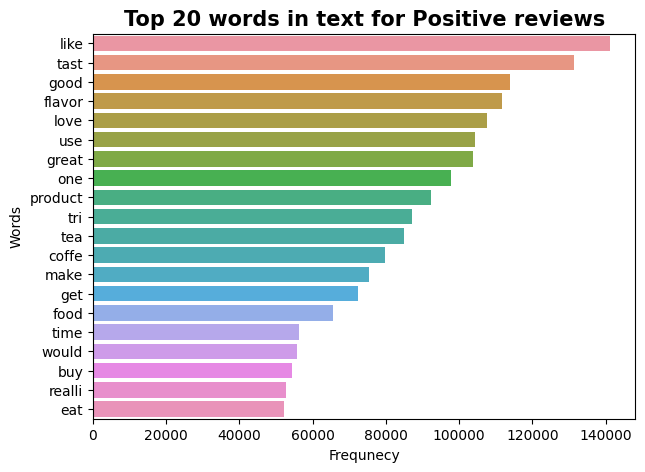

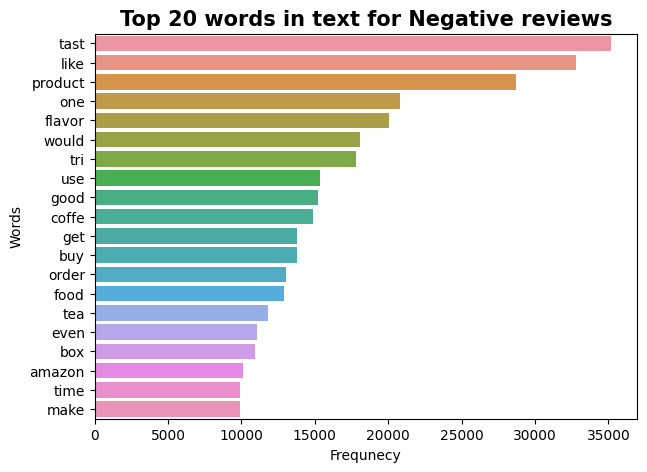

In [ ]:
# plot bar chart to visualize the frequency of words in the text of each sentiment
from wordcloud import STOPWORDS
def plot_bar_chart(sentiment):
    text = filtered[filtered['Sentiment'] == sentiment]['Text'].values
    text = ' '.join(text)
    text = text.split()
    text = pd.Series(text).value_counts()
    text = text[:20,]
    plt.figure(figsize=(7,5))
    plt.title('Top 20 words in text for {} reviews'.format(sentiment), fontsize=15, fontweight='bold')
    sns.barplot(x=text.values, y=text.index)
    plt.xlabel("Frequnecy")
    plt.ylabel("Words")
    plt.show()
plot_bar_chart('Positive')
plot_bar_chart('Negative')

### WordCloud Analysis

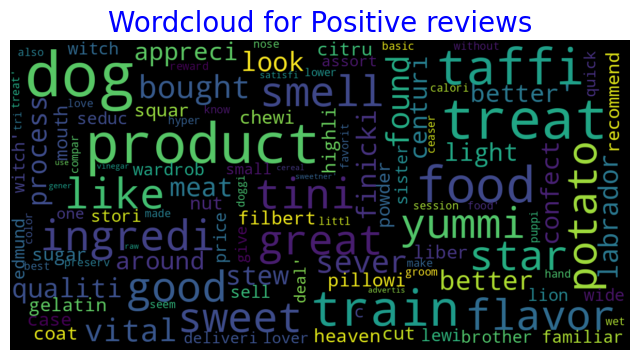

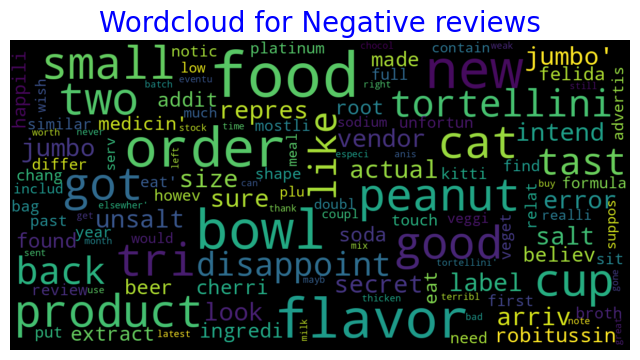

In [ ]:
# plot a bar plot to visualize the word frequency of each label
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
def plot_wordcloud(sentiment):
    text = filtered[filtered['Sentiment'] == sentiment]['Text'].values
    wordcloud = WordCloud(scale=3, max_words=200, max_font_size=40, colormap= 'viridis', random_state=42, stopwords=stop_words).generate(str(text))
    plt.figure(figsize=(8,8))
    plt.title('Wordcloud for {} reviews'.format(sentiment), fontsize=20, color='blue')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

plot_wordcloud('Positive')
plot_wordcloud('Negative')

#  Vectorization

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

x = filtered['Text']
y = filtered['Class_Labels'].values
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# bi gram bag of words
from sklearn.feature_extraction.text import CountVectorizer
two_gram_vectorizer = CountVectorizer(ngram_range=(1,2))
bow_train = two_gram_vectorizer.fit_transform(X_train)
bow_test = two_gram_vectorizer.transform(X_test)
bow_input = {"x_train": bow_train, "x_test": bow_test, "y_train": y_train, "y_test": y_test}

In [ ]:
# tf-idf
tfidf = TfidfVectorizer()
tfid_train = tfidf.fit_transform(X_train)
tfid_test = tfidf.transform(X_test)
tfid_input = {"x_train": tfid_train, "x_test": tfid_test, "y_train": y_train, "y_test": y_test}

## Train Models

- Traditional ML: Naive Bayes, Logistic Regression, XGBOOST

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = round(accuracy_score(y_test, y_pred), 2)
    precision = round(precision_score(y_test, y_pred), 2)
    recall = round(recall_score(y_test, y_pred), 2)
    f1 = round(f1_score(y_test, y_pred), 2)

    print('Accuracy of the model: {}'.format(accuracy))
    print('Precision of the model: {}'.format(precision))
    print('Recall of the model: {}'.format(recall))
    print('F1 score of the model: {}'.format(f1))

    sns.set_context('notebook', font_scale= 1.2)
    # plot the confusion matrix
    confusion_matrix =metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display.plot()
    plt.show()  


## Naive Bayes


Accuracy of the model: 0.9
Precision of the model: 0.89
Recall of the model: 0.99
F1 score of the model: 0.94


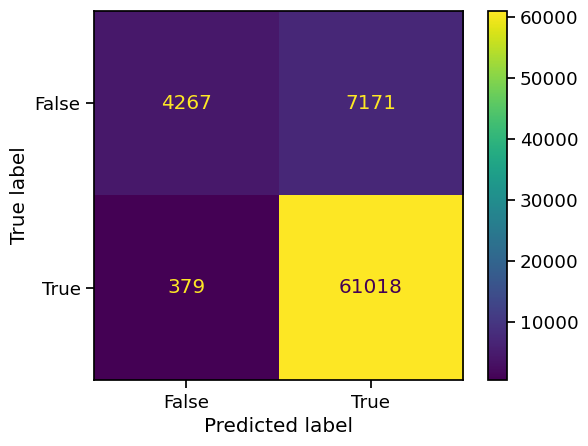

In [ ]:
# bow input
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
nb = MultinomialNB()
train_model(nb, bow_input['x_train'], bow_input['y_train'], bow_input['x_test'], bow_input['y_test'])

Accuracy of the model: 0.86
Precision of the model: 0.86
Recall of the model: 1.0
F1 score of the model: 0.92


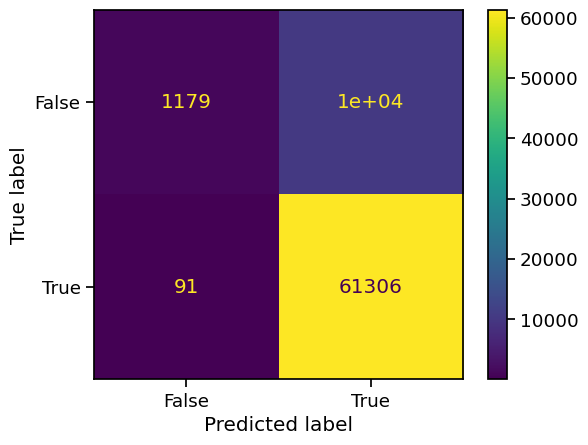

In [ ]:
# rf-idf input
train_model(nb, tfid_input['x_train'], tfid_input['y_train'], tfid_input['x_test'], tfid_input['y_test'])

### Logistic Regression

Accuracy of the model: 0.94
Precision of the model: 0.95
Recall of the model: 0.97
F1 score of the model: 0.96


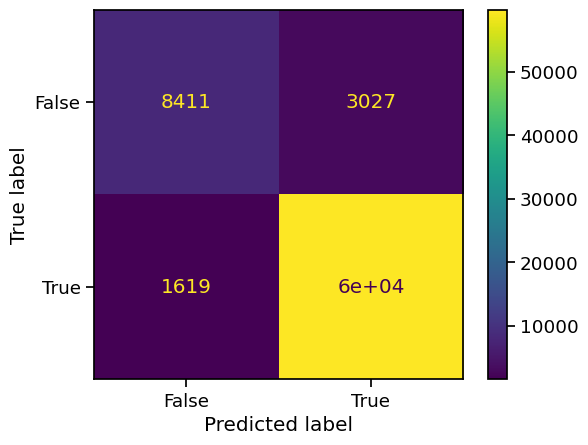

In [ ]:
# bow data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
train_model(lr, bow_input['x_train'], bow_input['y_train'], bow_input['x_test'], bow_input['y_test'])

Accuracy of the model: 0.92
Precision of the model: 0.94
Recall of the model: 0.98
F1 score of the model: 0.96


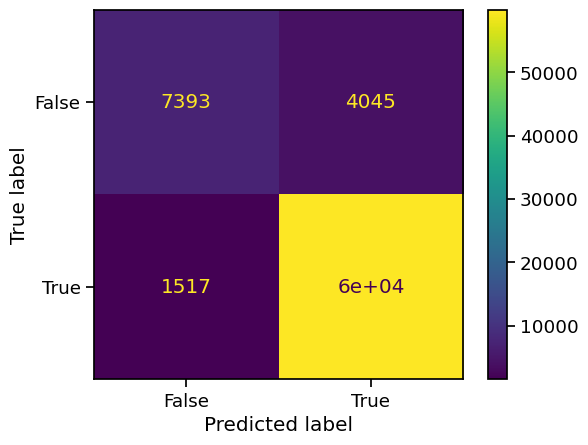

In [ ]:
#tf-idf input
train_model(lr, tfid_input['x_train'], tfid_input['y_train'], tfid_input['x_test'], tfid_input['y_test'])

## XGBOOST

Accuracy of the model: 0.91
Precision of the model: 0.91
Recall of the model: 0.98
F1 score of the model: 0.95


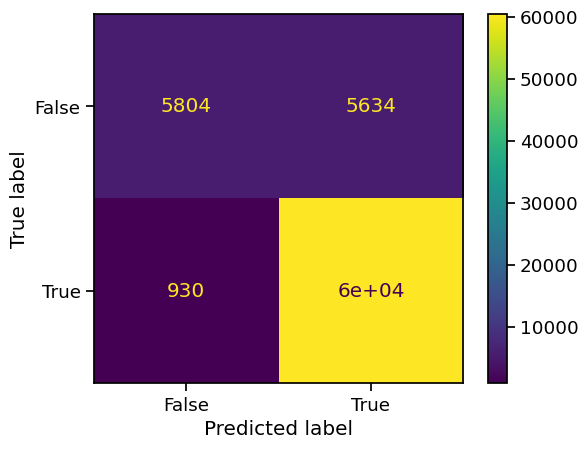

In [ ]:
# bow data
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
train_model(xgb_model, bow_input['x_train'], bow_input['y_train'], bow_input['x_test'], bow_input['y_test'])

Accuracy of the model: 0.91
Precision of the model: 0.91
Recall of the model: 0.98
F1 score of the model: 0.95


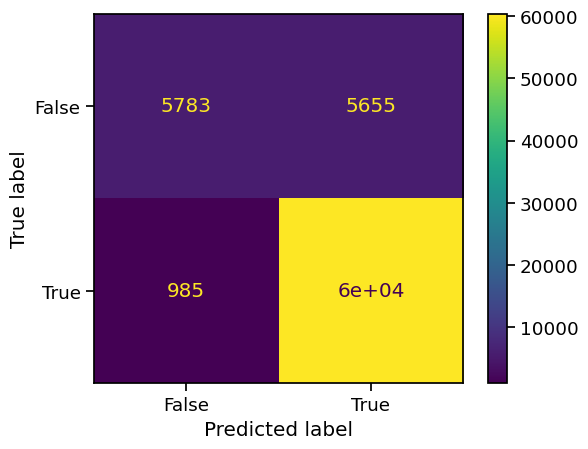

In [ ]:
# tf-idf data
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
train_model(xgb_model, tfid_input['x_train'], tfid_input['y_train'], tfid_input['x_test'], tfid_input['y_test'])

# Deep Learning 
## LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import train_test_split

### Tokenizing the dataset

In [ ]:
# Tokenizing the dataset
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train)

embedding_vector_length = 32
max_review_length = 300

# Bag-of-Words vectorization using keras build-in function
x_train_bow = tokenizer.texts_to_sequences(X_train)
x_test_bow = tokenizer.texts_to_sequences(X_test)


# TFIDF vectorization using keras build-in function
x_train_tfid  = tokenizer.texts_to_matrix(X_train, mode='tfidf')
x_test_tfid = tokenizer.texts_to_matrix(X_test, mode='tfidf')

### Padding the dataset

In [ ]:
## Padding Texts Lengths
x_train_bow = pad_sequences(x_train_bow, maxlen=max_review_length)
x_test_bow = pad_sequences(x_test_bow, maxlen=max_review_length)

x_train_tfid = pad_sequences(x_train_tfid, maxlen=max_review_length)
x_test_tfid = pad_sequences(x_test_tfid, maxlen=max_review_length)

In [ ]:
vocab_size_bow = bow_input['x_train'].shape[1]
vocab_size_tfid = tfid_input['x_train'].shape[1]

In [ ]:
# Build Model
#vocab_size_bow = bow_input['x_train'].shape[1]
#vocab_size_tfid = tfid_input['x_train'].shape[1]
#embedding_vector_length = 32
#max_review_length = 200

##trim the input to 200 or the ram would be exploded
#x_train_bow = pad_sequences(bow_input['x_train'].toarray(), maxlen=max_review_length)
#x_test_bow = pad_sequences(bow_input['x_test'].toarray(), maxlen=max_review_length)

#x_train_tfid = pad_sequences(tfid_input['x_train'].toarray(), maxlen=max_review_length)
#x_test_tfid = pad_sequences(tfid_input['x_test'].toarray(), maxlen=max_review_length)


### Fitting LSTM with Embedding layer
Embedding -> LSTM -> LSTM -> Dense(Output(Sigmoid))

In [ ]:
from keras.layers import Bidirectional, CuDNNLSTM
from IPython.core import history
def train_LSTM_1(input_dim, embedding_vector_length, max_review_length, x_train, y_train, x_test, y_test):
  model = Sequential()
  model.add(Embedding(input_dim, embedding_vector_length, input_length =max_review_length))
  model.add(CuDNNLSTM(100, return_sequences = True))
  model.add(CuDNNLSTM(100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Print Model Summary
  print("***********************************************")
  print("Printing the Model Summary")
  print(model.summary())
  print("***********************************************")

  # Train Model
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
  result = model.evaluate(x_test, y_test, verbose=0)
  
  prediction = model.predict(x_test)
  y_pred = (prediction > 0.5)

  
  precision = round(precision_score(y_test, y_pred), 2)
  recall = round(recall_score(y_test, y_pred), 2)
  f1 = round(f1_score(y_test, y_pred), 2)


  # Results
  print("Test Score:", result[0])
  print("Test Accuracy:", result[1])
  print('Precision of the model: {}'.format(precision))
  print('Recall of the model: {}'.format(recall))
  print('F1 score of the model: {}'.format(f1))

  #Accuract Plot
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  sns.set_context('notebook', font_scale= 1.2)
  # Plot the confusion matrix
  confusion_matrix =metrics.confusion_matrix(y_test, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

  cm_display.plot()
  plt.show()  

***********************************************
Printing the Model Summary
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 32)           83214144  
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 300, 100)          53600     
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 100)               80800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 83,348,645
Trainable params: 83,348,645
Non-trainable params: 0
_________________________________________________________________
None
***********************************************
Epoch 1/5
2277/2277 [===========================

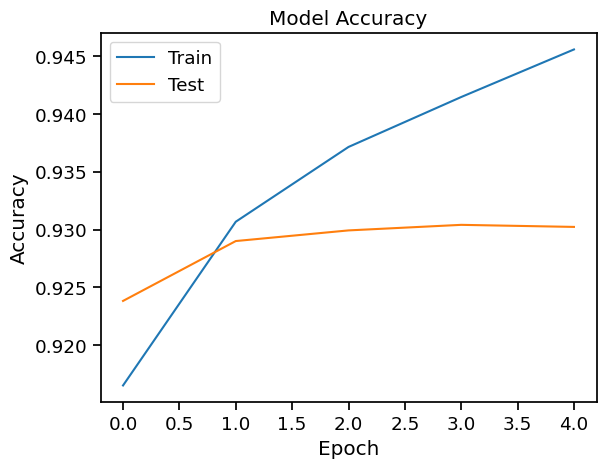

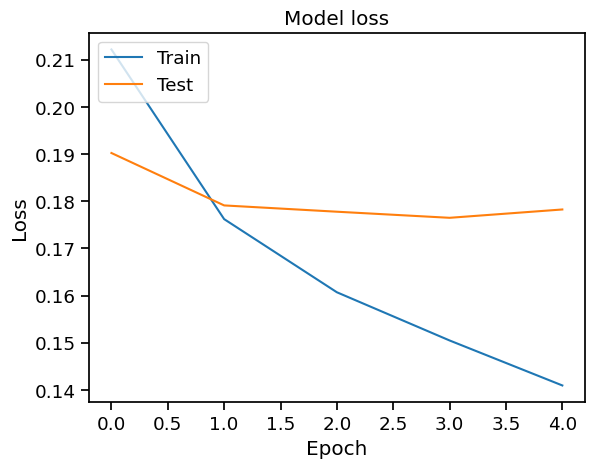

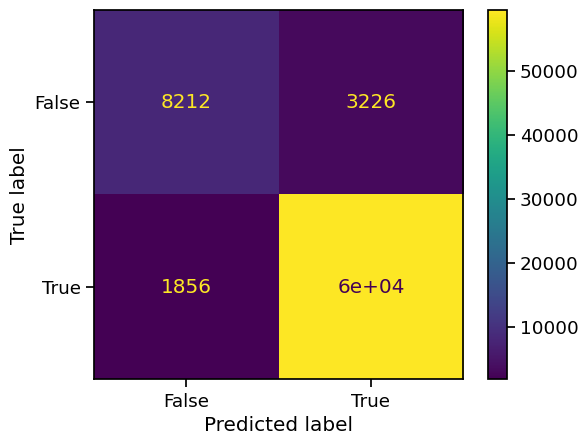

In [ ]:
train_LSTM_1(vocab_size_bow,embedding_vector_length, max_review_length, x_train_bow, bow_input['y_train'], x_test_bow, bow_input['y_test'])

***********************************************
Printing the Model Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 32)           2055232   
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 300, 100)          53600     
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 100)               80800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 2,189,733
Trainable params: 2,189,733
Non-trainable params: 0
_________________________________________________________________
None
***********************************************
Epoch 1/5
2277/2277 [===========================

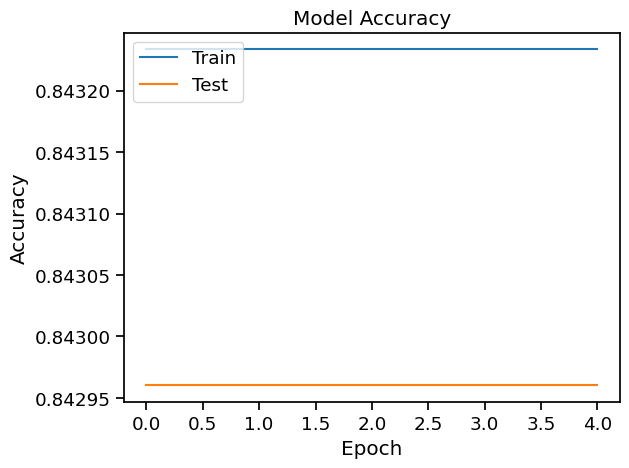

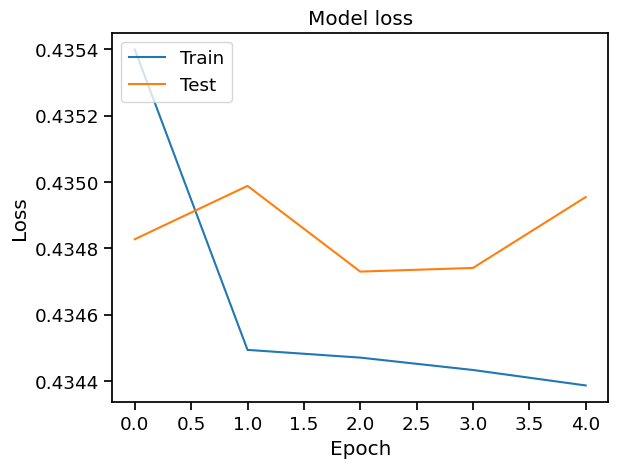

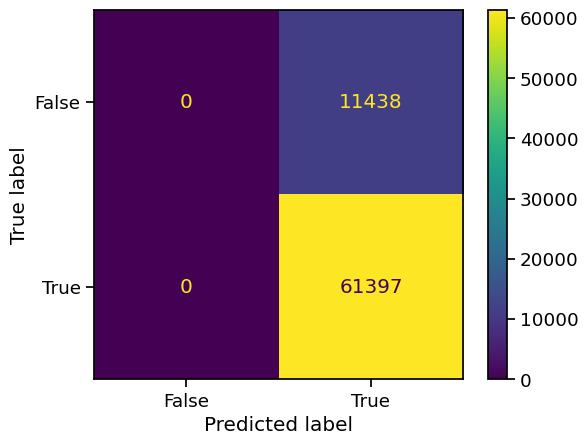

In [ ]:
train_LSTM_1(vocab_size_tfid,embedding_vector_length, max_review_length, x_train_tfid, tfid_input['y_train'], x_test_tfid, tfid_input['y_test'])

## Architecture #2
- Embedding -> LSTM -> Dropout -> LSTM -> Dropout -> Dense(Output(Sigmoid))

In [ ]:
from keras.layers import Dropout
# Build Model
def train_LSTM_2(vocab_size, embedding_vector_length, max_review_length,x_train, y_train, x_test, y_test):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_vector_length, input_length =max_review_length))
  model.add(CuDNNLSTM(100, return_sequences=True))
  model.add(Dropout(0.5))
  model.add(CuDNNLSTM(100))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


  # Print Model Summary
  print("***********************************************")
  print("Printing the Model Summary")
  print(model.summary())
  print("***********************************************")
  
  # Train Model
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=5)
  result = model.evaluate(x_test, y_test, verbose=0)

  prediction = model.predict(x_test)
  y_pred = (prediction > 0.5)

  
  precision = round(precision_score(y_test, y_pred), 2)
  recall = round(recall_score(y_test, y_pred), 2)
  f1 = round(f1_score(y_test, y_pred), 2)


  # Results
  print("Test Score:", result[0])
  print("Test Accuracy:", result[1])
  print('Precision of the model: {}'.format(precision))
  print('Recall of the model: {}'.format(recall))
  print('F1 score of the model: {}'.format(f1))



  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  sns.set_context('notebook', font_scale= 1.2)
  # Plot the confusion matrix
  confusion_matrix =metrics.confusion_matrix(y_test, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

  cm_display.plot()
  plt.show()  

***********************************************
Printing the Model Summary
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           83214144  
                                                                 
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 300, 100)          53600     
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 100)               80800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                             

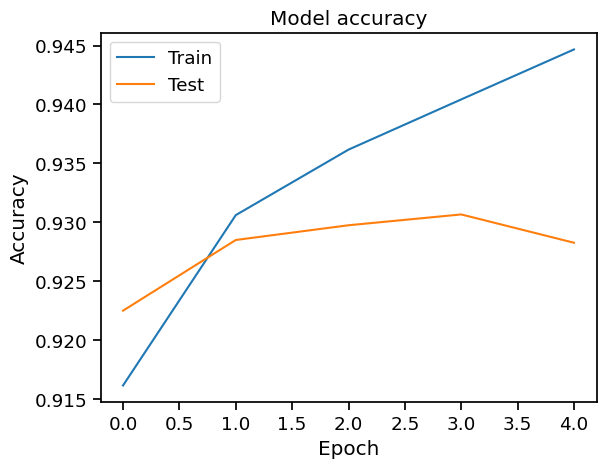

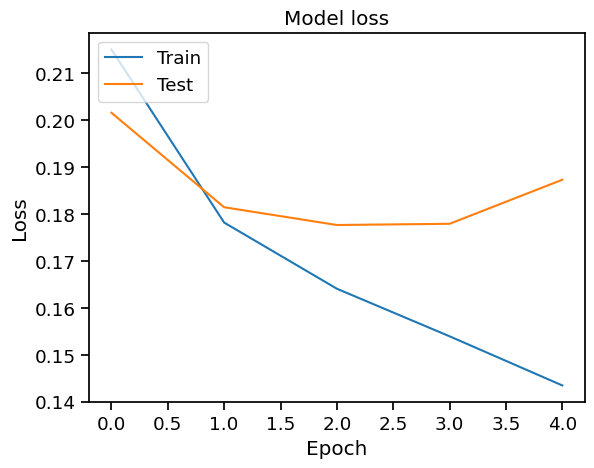

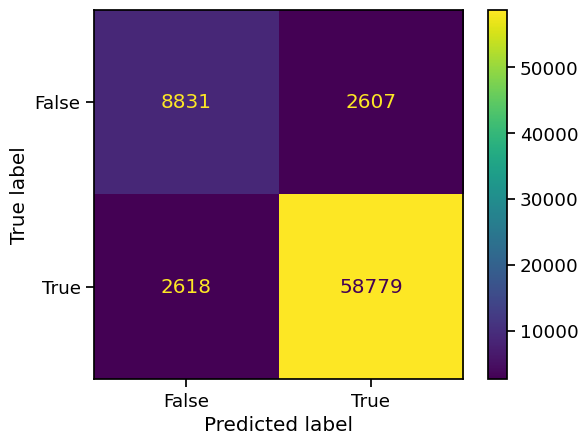

In [ ]:
train_LSTM_2(vocab_size_bow,embedding_vector_length, max_review_length, x_train_bow, bow_input['y_train'], x_test_bow, bow_input['y_test'])

***********************************************
Printing the Model Summary
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 32)           2055232   
                                                                 
 cu_dnnlstm_6 (CuDNNLSTM)    (None, 300, 100)          53600     
                                                                 
 dropout_2 (Dropout)         (None, 300, 100)          0         
                                                                 
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 100)               80800     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                             

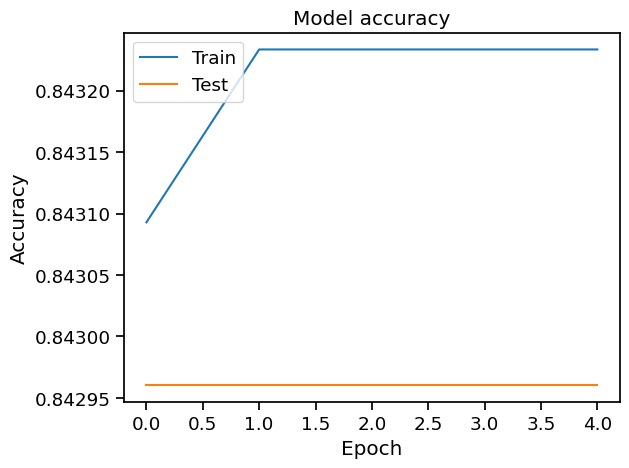

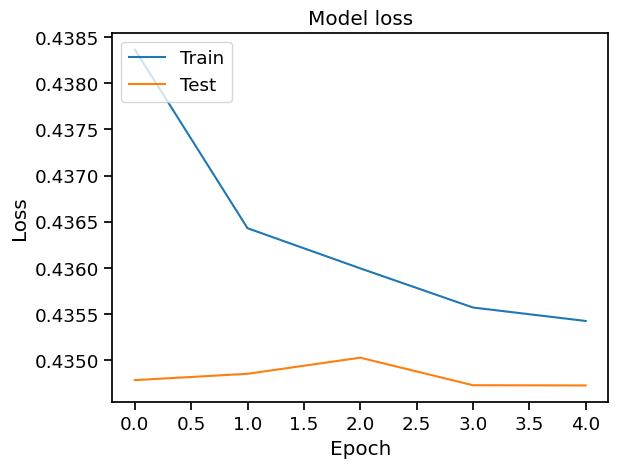

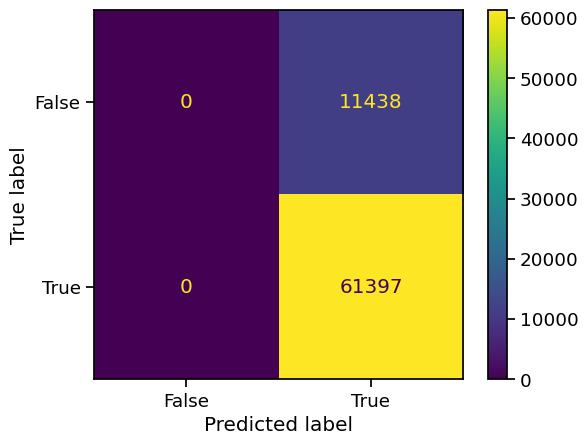

In [ ]:
train_LSTM_2(vocab_size_tfid,embedding_vector_length, max_review_length, x_train_tfid, bow_input['y_train'], x_test_tfid, bow_input['y_test'])

# Hyperparameter Tuning

In [ ]:
from keras.layers import Bidirectional, CuDNNLSTM
from keras.optimizers import Adam
from IPython.core import history
import time
import keras

def HPT_LSTM1(input_dim, embedding_vector_length, max_review_length, x_train, y_train, x_test, y_test, params):
  S_time = time.time()
  hyperparameters = params

  results = []
  for params in hyperparameters:
    keras.backend.clear_session()

    start_time = time.time()

    print (params)
    lstm_units = params['lstm_units']
    learn_rate = params['lr']
    batch = params['batch_size']
    epc = params['epochs']

    model = Sequential()

    # Create layers with specified size
    model.add(Embedding(input_dim, embedding_vector_length, input_length =max_review_length))
    model.add(CuDNNLSTM(lstm_units, return_sequences = True))
    model.add(CuDNNLSTM(lstm_units))
    model.add(Dense(1, activation='sigmoid'))

    # Test hyperparameter of learning rate
    opt = Adam(lr = learn_rate)
    model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])

    # Train Model with hyperparameters of batch size and number of epochs
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch, epochs=epc)
    result = model.evaluate(x_test, y_test, verbose=0)
    
    prediction = model.predict(x_test)
    y_pred = (prediction > 0.5)

    
    precision = round(precision_score(y_test, y_pred), 4)
    recall = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)

    results.append({
            'lstm_units_1': params['lstm_units'],
            'lstm_units_2': params['lstm_units'],
            'lr': params['lr'],
            'batch_size': params['batch_size'],
            'epochs': params['epochs'], 
            'loss': round(result[0], 4), 
            'accuracy': round(result[1], 4), 
            'Precision': precision, 
            'recall': recall, 
            'F1': f1})
    print (results[-1])

    runtime = (time.time() - start_time)/60
    print("Runtime in minutes:", round(runtime, 2))
    print ()
    # print ()
    # print ()

    
  df_results = pd.DataFrame(results)
  print (df_results)
  tot_runtime = (time.time() - S_time)/60
  print("Total Runtime in minutes:", round(tot_runtime, 2))

  return df_results

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameters to search over
param_grid = {
          'lstm_units': [64, 128, 256],
          'lr': [0.001, 0.002, 0.005],
          'batch_size': [96, 128, 256],
          'epochs': [3, 5, 7]}

param_list = list(ParameterGrid(param_grid))
len(param_list)

81

In [ ]:
X_train_val, X_val, y_train_val, y_val = train_test_split(x_test_bow, bow_input['y_test'], test_size=0.2, random_state=42)

In [ ]:
HPT_Result = HPT_LSTM1(vocab_size_bow,embedding_vector_length, max_review_length, X_train_val, y_train_val, X_val, y_val, param_list)

{'batch_size': 96, 'epochs': 3, 'lr': 0.001, 'lstm_units': 64}
Epoch 1/3
607/607 [==============================] - 24s 38ms/step - loss: 0.2786 - accuracy: 0.8901 - val_loss: 0.2213 - val_accuracy: 0.9116
Epoch 2/3
607/607 [==============================] - 23s 38ms/step - loss: 0.1947 - accuracy: 0.9241 - val_loss: 0.2041 - val_accuracy: 0.9190
Epoch 3/3
456/456 [==============================] - 4s 8ms/step
{'lstm_units_1': 64, 'lstm_units_2': 64, 'lr': 0.001, 'batch_size': 96, 'epochs': 3, 'loss': 0.2069, 'accuracy': 0.919, 'Precision': 0.9302, 'recall': 0.9776, 'F1': 0.9533}
Runtime in minutes: 1.53

{'batch_size': 96, 'epochs': 3, 'lr': 0.001, 'lstm_units': 128}
Epoch 1/3
607/607 [==============================] - 27s 42ms/step - loss: 0.2658 - accuracy: 0.8957 - val_loss: 0.2135 - val_accuracy: 0.9180
Epoch 2/3
607/607 [==============================] - 25s 41ms/step - loss: 0.1920 - accuracy: 0.9255 - val_loss: 0.2384 - val_accuracy: 0.9139
Epoch 3/3
456/456 [==================

In [ ]:
HPT_Result.to_csv('/content/drive/Shareddrives/CIS 519 Project/HyperparameterTuning_Result.csv')


In [ ]:
# Obtain the optimal hyperparameters from the tuning results above, with the record of highest F1 score
# best_record = HPT_Result.sort_values(by = 'F1', ascending = False).values[0]
# opt_lstm_unit = best_record[0]
# opt_lr = best_record[2]
# opt_batch_size = best_record[3]
# opt_epochs = best_record[4]

# opt_param_grid = {
#           'lstm_units': int(opt_lstm_unit),
#           'lr': opt_lr,
#           'batch_size': int(opt_batch_size),
#           'epochs': int(opt_epochs)}
# print (opt_param_grid)

# To save the optimal hyperparameters below
def_opt_param_grid = {
          'lstm_units': 64,
          'lr': 0.002,
          'batch_size': 96,
          'epochs': 3}

# print (HPT_Result.sort_values(by = 'F1', ascending = False))
print (def_opt_param_grid)

{'lstm_units': 128, 'lr': 0.002, 'batch_size': 256, 'epochs': 3}
{'lstm_units': 64, 'lr': 0.002, 'batch_size': 96, 'epochs': 3}


Train the optimal structure with optimal hyperparameters

In [ ]:
from keras.layers import Bidirectional, CuDNNLSTM
from IPython.core import history
def train_optimal_LSTM(input_dim, embedding_vector_length, max_review_length, x_train, y_train, x_test, y_test, opt_param_grid):
  print (opt_param_grid)
  lstm_units = opt_param_grid['lstm_units']
  learn_rate = opt_param_grid['lr']
  batch = opt_param_grid['batch_size']
  epc = opt_param_grid['epochs']
  
  model = Sequential()
  model.add(Embedding(input_dim, embedding_vector_length, input_length =max_review_length))
  model.add(CuDNNLSTM(lstm_units, return_sequences = True))
  model.add(CuDNNLSTM(lstm_units))
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(lr = learn_rate)
  model.compile(loss='binary_crossentropy', optimizer = opt, metrics=['accuracy'])

  # Print Model Summary
  print("***********************************************")
  print("Printing the Model Summary")
  print(model.summary())
  print("***********************************************")

  # Train Model
  history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch, epochs=epc)
  result = model.evaluate(x_test, y_test, verbose=0)
  
  prediction = model.predict(x_test)
  y_pred = (prediction > 0.5)

  
  precision = round(precision_score(y_test, y_pred), 2)
  recall = round(recall_score(y_test, y_pred), 2)
  f1 = round(f1_score(y_test, y_pred), 2)


  # Results
  print("Test Score:", result[0])
  print("Test Accuracy:", result[1])
  print('Precision of the model: {}'.format(precision))
  print('Recall of the model: {}'.format(recall))
  print('F1 score of the model: {}'.format(f1))

  #Accuract Plot
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  sns.set_context('notebook', font_scale= 1.2)
  # Plot the confusion matrix
  confusion_matrix =metrics.confusion_matrix(y_test, y_pred)
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

  cm_display.plot()
  plt.show()  

In [ ]:
# train_optimal_LSTM(vocab_size_bow,embedding_vector_length, max_review_length, x_train_bow, bow_input['y_train'], x_test_bow, bow_input['y_test'], opt_param_grid)

{'lstm_units': 64, 'lr': 0.002, 'batch_size': 96, 'epochs': 3}
***********************************************
Printing the Model Summary
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           83214144  
                                                                 
 cu_dnnlstm_4 (CuDNNLSTM)    (None, 300, 64)           25088     
                                                                 
 cu_dnnlstm_5 (CuDNNLSTM)    (None, 64)                33280     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,272,577
Trainable params: 83,272,577
Non-trainable params: 0
_________________________________________________________________
None
*******************************

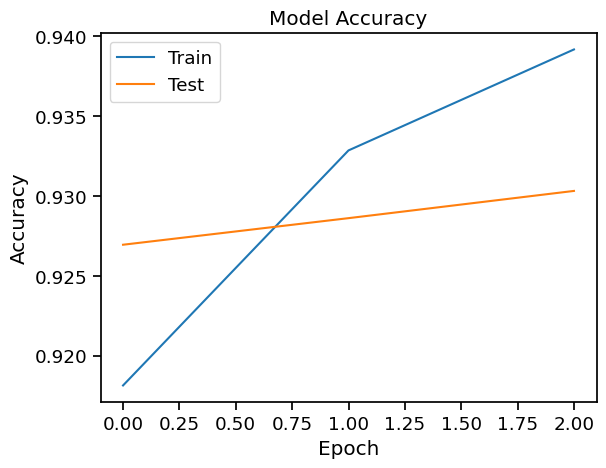

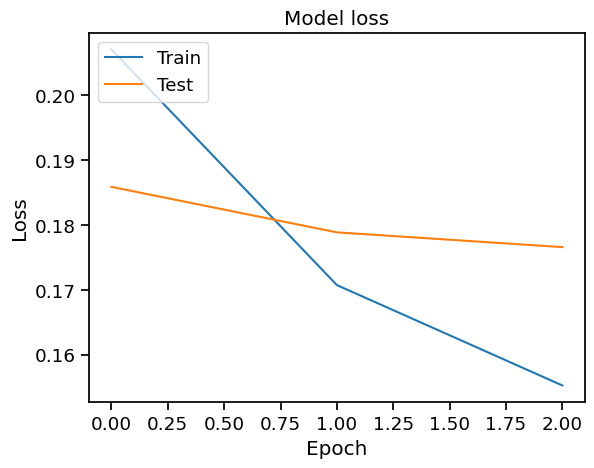

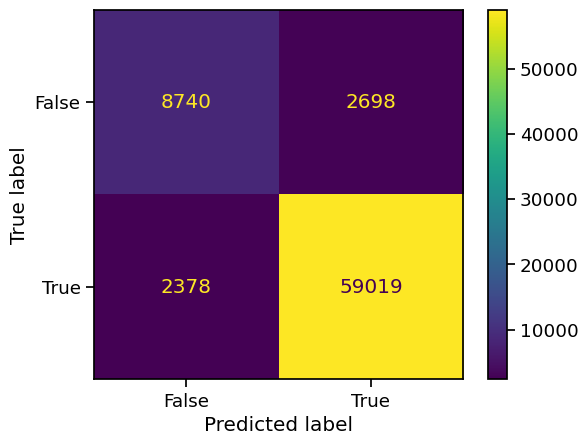

In [ ]:
train_optimal_LSTM(vocab_size_bow,embedding_vector_length, max_review_length, x_train_bow, bow_input['y_train'], x_test_bow, bow_input['y_test'], def_opt_param_grid)